#**TCS Stock Analysis Project**
##**Introduction**
This notebook analyzes Tata Consultancy Services (TCS) stock from 2020 to present using Yahoo Finance data. It covers data acquisition, cleaning, feature engineering, and visualizations to derive meaningful insights about stock performance.

In [107]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# Set plotting styles for better visuals
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [108]:
!pip install mplfinance


##**Data Acquisition and Saving Raw Data**

In [109]:
# Define Ticker and Date Range
ticker = 'TCS.NS'
start_date = '2020-01-01'
end_date = date.today()

# Download raw data (unadjusted)
df_raw = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# Save raw data for reproducibility and reference
df_raw.to_csv('TCS_Original_Raw_Data.csv', index=True)
print("Saved original raw data to TCS_Original_Raw_Data.csv")




[*********************100%***********************]  1 of 1 completed

Saved original raw data to TCS_Original_Raw_Data.csv


*Insight:*    Raw data includes splits and dividends unadjusted, useful for detailed transaction records or dividend analysis

##**Download Adjusted Data**

In [110]:
# Download adjusted data for analysis (auto_adjust=True)
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# Flatten multi-level columns if any, to avoid column access issues
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Drop rows with missing values for analysis consistency
df.dropna(inplace=True)

print(f"Successfully downloaded adjusted data for {ticker} from {start_date} to {end_date}.")

[*********************100%***********************]  1 of 1 completed

Successfully downloaded adjusted data for TCS.NS from 2020-01-01 to 2025-10-31.


*Insight:* Adjusted data accounts for dividends and splits providing a continuous price series for analysis

##**Initial Data Inspection**

In [111]:
print(f"Dataset Shape: {df.shape}")
print(df.info())
print(df.head())
print(df.describe())

Dataset Shape: (1445, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1445 entries, 2020-01-01 to 2025-10-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1445 non-null   float64
 1   High    1445 non-null   float64
 2   Low     1445 non-null   float64
 3   Open    1445 non-null   float64
 4   Volume  1445 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 67.7 KB
None
Price             Close         High          Low         Open   Volume
Date                                                                   
2020-01-01  1900.037842  1914.325646  1888.116501  1900.388381  1354908
2020-01-02  1891.315918  1910.863314  1883.909004  1910.863314  2380752
2020-01-03  1929.008057  1948.599323  1896.882112  1896.882112  4655761
2020-01-06  1928.833130  1951.185488  1917.832221  1932.821535  3023209
2020-01-07  1933.566162  1941.279744  1914.237909  1928.876465  2429317
Price        Close         High 

##**Feature Engineering: Technical Indicators**

In [112]:
#Moving Averages Calculation
#Calculate simple moving averages for trend analysis
# Moving averages: 20, 50, 200 days(Using min_periods=1 so early rows are populated instead of NaN)
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()  # Short-term trend
df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()  # Medium-term trend
df['MA200'] = df['Close'].rolling(window=200, min_periods=1).mean()# Long-term trend

# Relative Strength Index (RSI) Calculation for momentum
# Use Series aligned to df.index and avoid initial NaNs
# Wilder's smoothing
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = (-delta).clip(lower=0)
avg_gain = gain.ewm(alpha=1/14, adjust=False, min_periods=1).mean()
avg_loss = loss.ewm(alpha=1/14, adjust=False, min_periods=1).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
# If desired, cap RSI to [0, 100]
rsi = rsi.clip(0, 100)
df['RSI'] = rsi

# MACD Calculation for momentum change
# Calculate MACD and Signal Line
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

##**Visualizations and Insights**

###**Price Trend with Moving Averages**

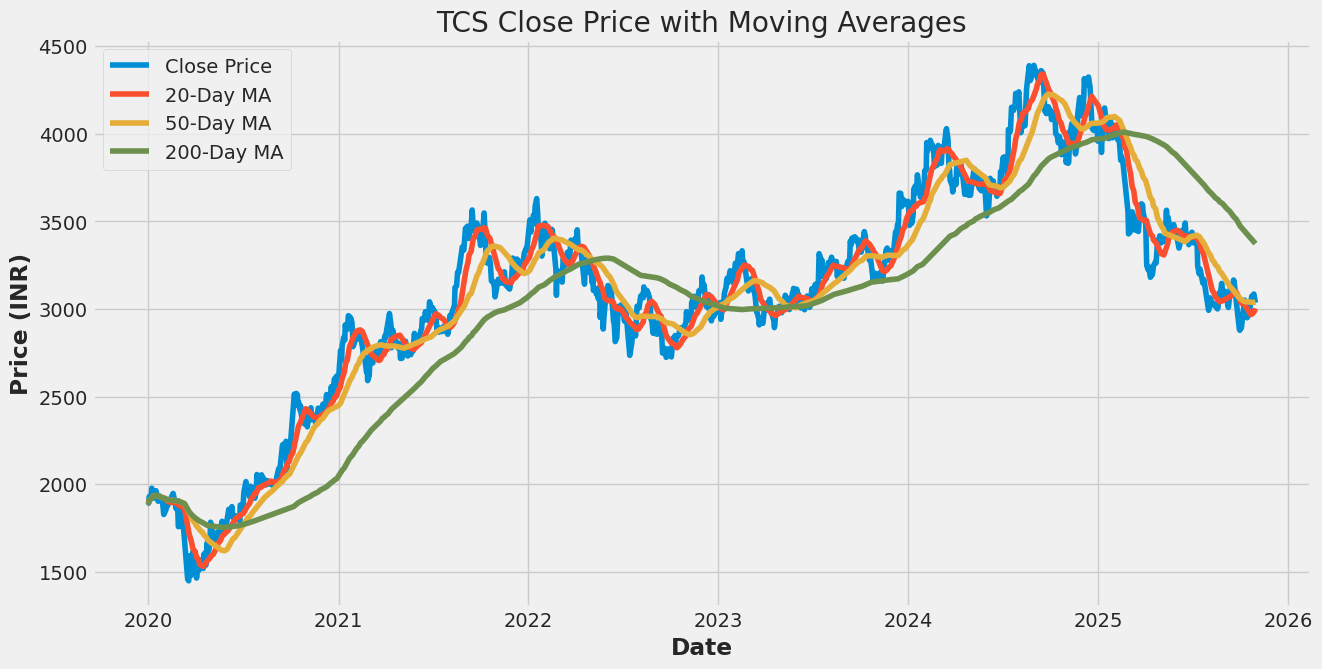

In [113]:
# Closing Price with Moving Averages
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA20'], label='20-Day MA')
plt.plot(df['MA50'], label='50-Day MA')
plt.plot(df['MA200'], label='200-Day MA')
plt.title('TCS Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

*Insight:* The general upward price trend is visible. Moving averages smooth out short-term noise and identify trend stability and potential reversals.

###**Candlestick Chart with Volume (Last 1 Year)**

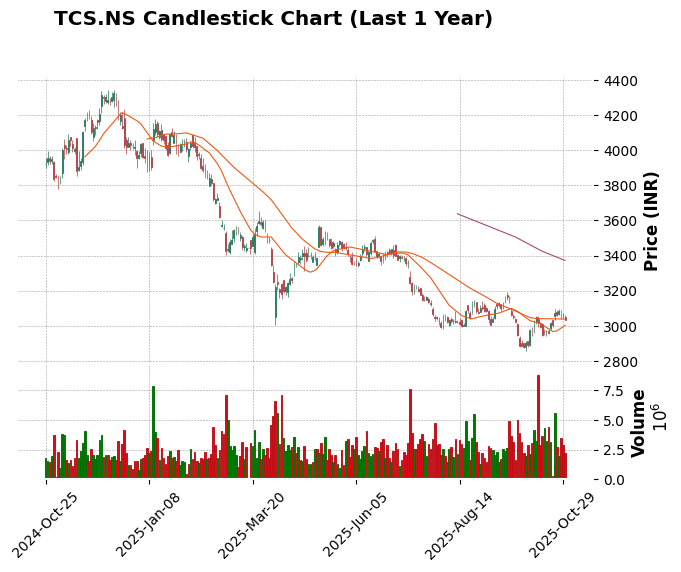

In [114]:
# Candlestick Chart for Last 1 Year with moving averages (20,50,200)
last_year_df = df.iloc[-252:]  # Approx 252 trading days ~ 1 year
mav = (20, 50, 200)
mpf.plot(last_year_df,
         type='candle',
         style='charles',
         title=f'{ticker} Candlestick Chart (Last 1 Year)',
         ylabel='Price (INR)',
         volume=True,
         mav=mav,
         ylabel_lower='Volume')

*Insight:* Price volatility, support, and resistance zones can be studied more granularly here.

###**RSI Momentum Indicator**

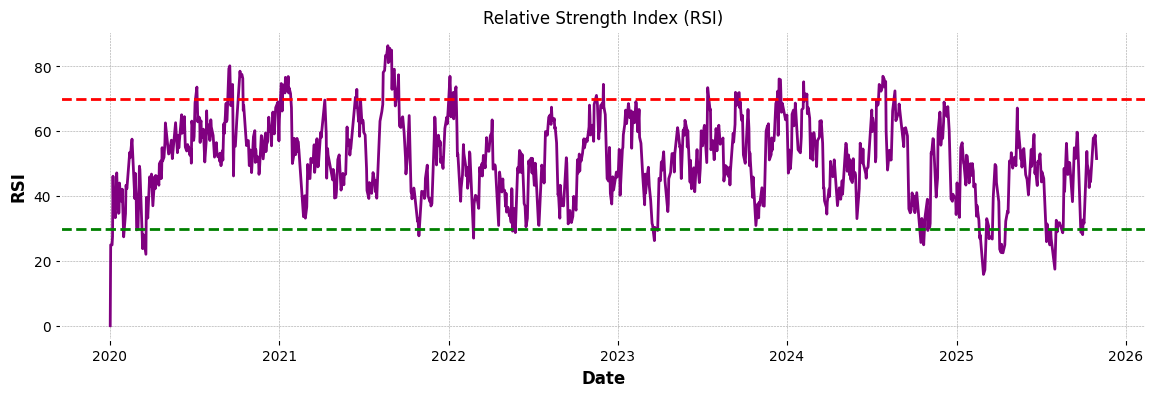

In [115]:
# RSI Plot
plt.figure(figsize=(14,4))
plt.plot(df['RSI'], color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

*Insight:* RSI values above 70 imply an overbought condition, signaling a potential pullback; below 30 indicates oversold and possible rebound

###**MACD & Signal Line**

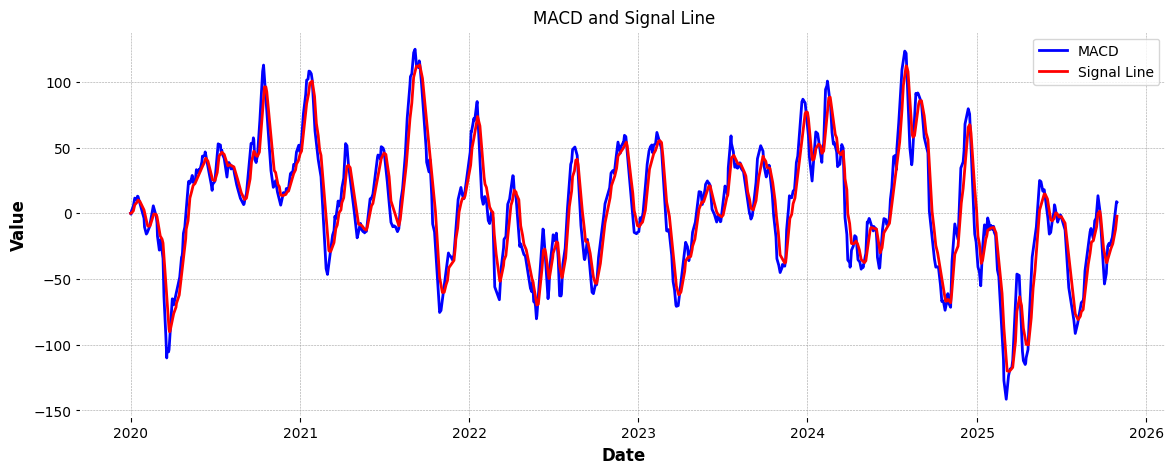

In [116]:
# MACD Plot
plt.figure(figsize=(14, 5))
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

*Insight:* MACD crossings with the signal line provide buy or sell signals based on momentum changes.

###**Distribution & Volatility of Daily Returns**

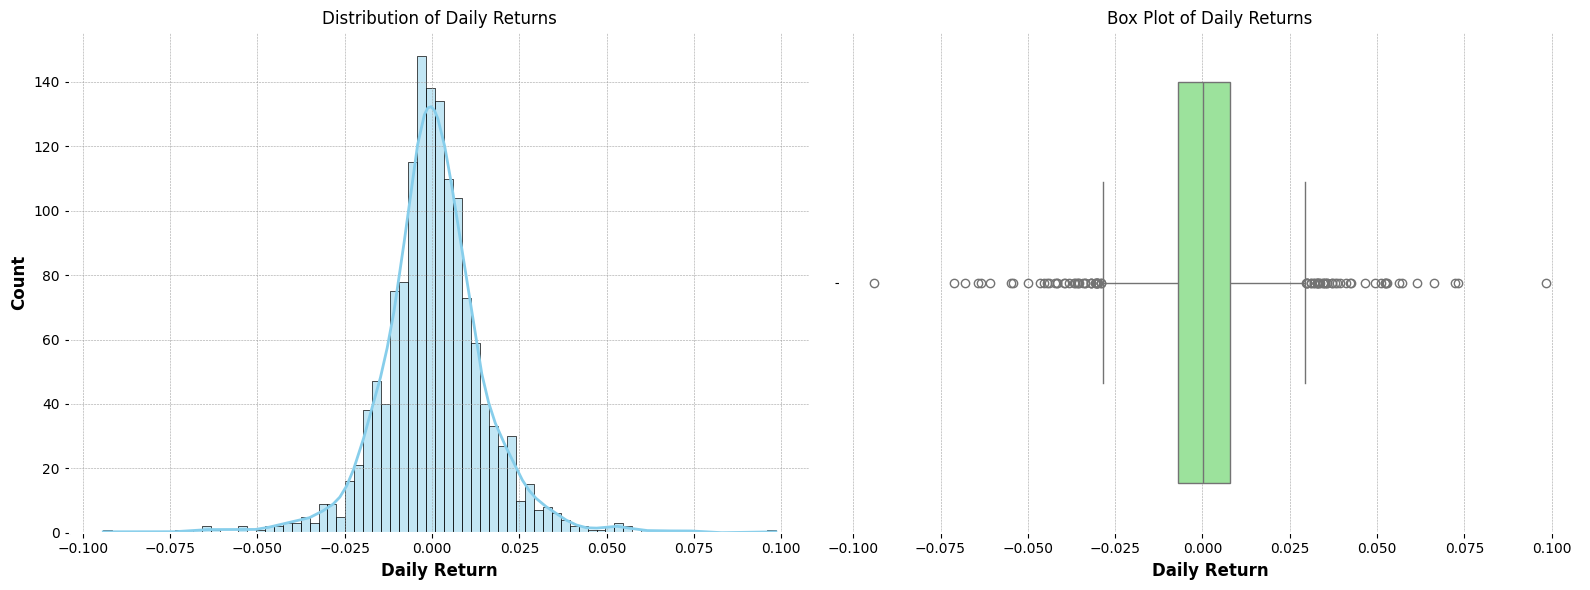

In [117]:
# Daily Returns Distribution & Volatility
df['Daily Return'] = df['Close'].pct_change()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Daily Return'].dropna(), kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Daily Returns')
sns.boxplot(x=df['Daily Return'].dropna(), ax=axes[1], color='lightgreen')
axes[1].set_title('Box Plot of Daily Returns')
plt.tight_layout()
plt.show()

*Insight:* Returns distribution is close to normal, yet the boxplot shows occasional large volatility spikes

###**Correlation Matrix**

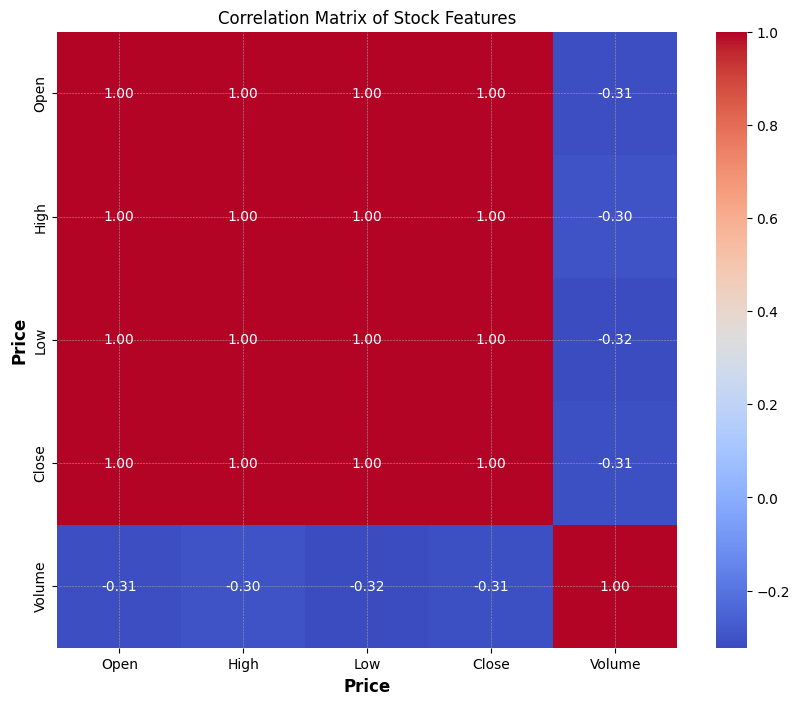

In [118]:
# Correlation Heatmap of Adjusted Prices and Volume
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Features')
plt.show()

*Insight:* Strong correlations among Open, High, Low, and Close prices; Volume shows lower correlation.

##**Yearly and Monthly Performance Insights**

###**Year-End Closing Price (Yearly)**

/tmp/ipython-input-4134174871.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_performance = df['Close'].resample('A').last()


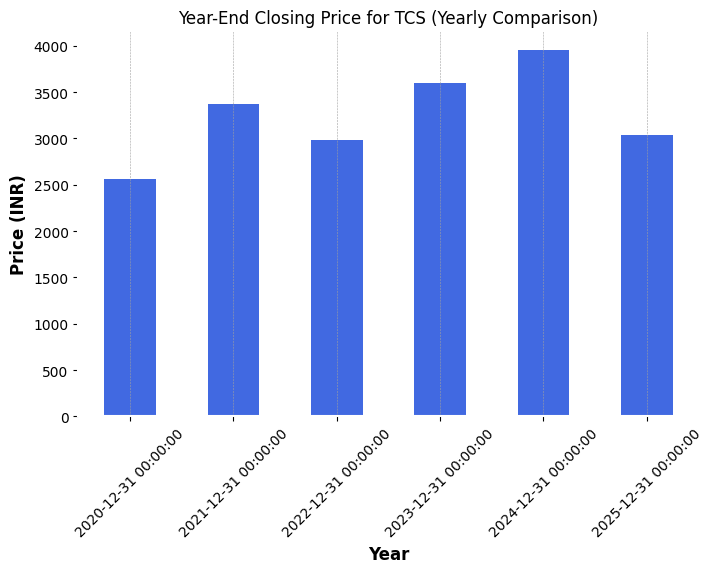

In [119]:
# Year-end closing price bar chart
yearly_performance = df['Close'].resample('A').last()
plt.figure(figsize=(8, 5))
yearly_performance.plot(kind='bar', color='royalblue')
plt.title('Year-End Closing Price for TCS (Yearly Comparison)')
plt.xlabel('Year')
plt.ylabel('Price (INR)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



*Insight:* Yearly bars illustrate overall growth trends with years of significant gains and any plateaus or declines.

###**Monthly Profit & Loss Heatmap**

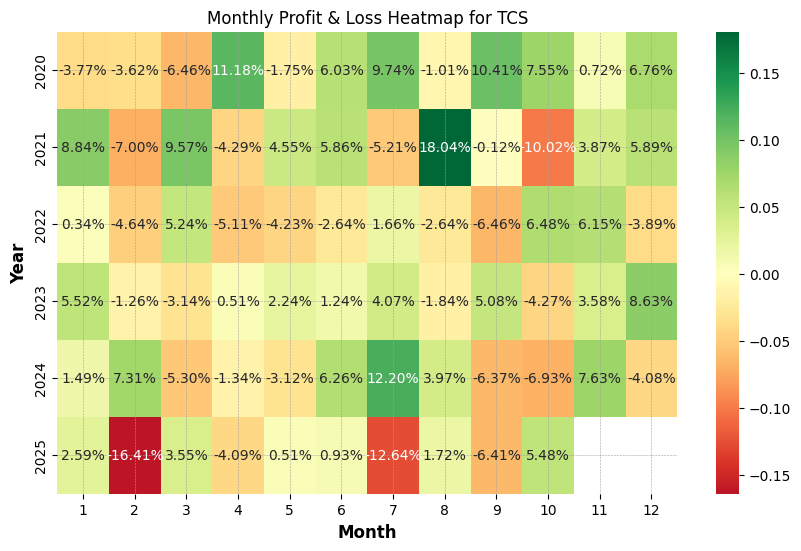

In [120]:
# Monthly profit/loss heatmap
df['Year'] = df.index.year
df['Month'] = df.index.month
monthly_returns = df.groupby(['Year', 'Month'])['Daily Return'].sum()
monthly_returns_df = monthly_returns.unstack(level=1)
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_returns_df, cmap='RdYlGn', annot=True, fmt='.2%', center=0)
plt.title('Monthly Profit & Loss Heatmap for TCS')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

*Insight:* Seasonal trends and the most/least profitable months become visually clear.

##**Export Cleaned Data to CSV**

In [121]:
df.to_csv('TCS_Adjusted_Stock_Analysis_1.csv', index=True)
print('Saved cleaned and enriched data to TCS_Adjusted_Stock_Analysis_1.csv')

Saved cleaned and enriched data to TCS_Adjusted_Stock_Analysis_1.csv


##**Summary**
- TCS stock shows steady
long-term growth with identifiable seasonal patterns.

- Technical indicators reveal momentum and possible price reversal windows.

- Volatility analysis highlights typical day-to-day fluctuation but overall stability.

- Yearly and monthly views provide performance benchmarks for investment decisions.